In [1]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,387 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [13]:
!pip install langchain unstructured[all-docs] faiss-cpu langchain_google_genai sentence-transformers

In [14]:
!pip install "google-generativeai" "pydash" "pillow" "pydantic==1.10.13"

In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.retrievers import MultiVectorRetriever
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

gemini_key=os.environ.get("GOOGLE_API_KEY")

In [32]:
path="./anatomy.pdf"
raw_pdf=partition_pdf(filename=path,
                      extract_images_in_pdf=True,
                      infer_table_structure=True,
                      chunking_strategy="by_title",
                      max_characters=4000,
                      new_after_n_chars=3800,
                      combine_text_under_n_chars=200,
                      extract_image_block_output_dir="./images")

In [33]:
text_elements=[]
table_elements=[]

text_summaries=[]
table_summaries=[]

summary_prompt="""
Summrize the following {element_type} that contains information about human anatomy:
{element}
"""

llm=ChatGoogleGenerativeAI(model="gemini-pro", convert_system_message_to_human=True,google_api_key=gemini_key)
summarize_chain=LLMChain(llm=llm, prompt=PromptTemplate.from_template(summary_prompt))

for element in raw_pdf:
  if "CompositeElement" in repr(element):
    text_elements.append(element.text)
    summary = summarize_chain.run({'element_type':'text','element':element})
    text_summaries.append(summary)
  elif "Table" in repr(element):
    table_elements.append(element.text)
    summary = summarize_chain.run({'element_type':'table','element':element})
    table_summaries.append(summary)


In [69]:
image_summaries=[]
image_elements=[]

def encode(img):
  with open(img,'rb') as f:
    return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(img):
  prompt=[
      SystemMessage(content="You are a bot that is good at analyzing images related to human anatomy"),
      HumanMessage(content=[
          {
              "type":"text",
              "text":"Explain elaborately about the content of image without stating the word image or diagram or other related word."
          },
          {
              "type":"image_url",
              "image_url":{
                  "url":f'data:image/jpeg;base64,{img}'
              }
          }
      ])
  ]
  vision_llm = ChatGoogleGenerativeAI(model="gemini-pro-vision", google_api_key=gemini_key, convert_system_message_to_human=True)
  res=vision_llm.invoke(prompt).content
  # print(res)
  return res

for i in os.listdir('./images'):
  if i.endswith(('.png','.jpg','.jpeg')):
    image_path=os.path.join('./images',i)
    encoded_image=encode(image_path)
    image_elements.append(encoded_image)
    image_summaries.append(summarize_image(encoded_image))

In [88]:
documents=[]
retrieved_contents=[]
for e,s in zip(text_elements,text_summaries):
  i=str(uuid.uuid4())
  doc=Document(
      page_content=s,
      metadata={
          'id':i,
          'type':'text',
          'orignal_content':e
      })
  retrieved_contents.append((i,e))
  documents.append(doc)

for e,s in zip(table_elements,table_summaries):
  i=str(uuid.uuid4())
  doc=Document(
      page_content=s,
      metadata={
          'id':i,
          'type':'table',
          'orignal_content':e
      })
  retrieved_contents.append((i,e))
  documents.append(doc)

for e, s in zip(image_elements, image_summaries):
  i = str(uuid.uuid4())
  doc = Document(
      page_content = s,
      metadata = {
      'id': i,
      'type': 'image',
      'orignal_content': e
      })
  retrieved_contents.append((i, s))
  documents.append(doc)

embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en", model_kwargs={"device": "cpu"}, encode_kwargs={"normalize_embeddings": True})
vectorstore=FAISS.from_documents(documents=documents, embedding=embeddings)

In [89]:
vectorstore.save_local("faiss_index")

In [91]:
db=FAISS.load_local('./faiss_index',embeddings)

In [92]:
prompt_tempelate="""
You are a doctor and have expertize in human anatomy.
Answer the following question based on the given context, which can include text, images and tables.
Context:{context}
Question:{question}
Elaborate the answer based on given context only.
Answer:"""

qa_chain=LLMChain(llm=ChatGoogleGenerativeAI(model='gemini-pro',convert_system_message_to_human=True, google_api_key=gemini_key), prompt=PromptTemplate.from_template(prompt_tempelate))

In [95]:
def answer(question):
  relevant_docs=db.similarity_search(question)
  print(relevant_docs)
  context=""
  relevant_images=[]
  for d in relevant_docs:
    if d.metadata['type']=='text':
      context+='[text]'+d.metadata['orignal_content']
    elif d.metadata['type']=='table':
      context+='[table]'+d.metadata['orignal_content']
    elif d.metadata['type']=='image':
      context+='[image]'+d.page_content
      relevant_images.append(d.metadata['orignal_content'])
  result=qa_chain.run({'context':context,"question":question})
  return result, relevant_images

In [96]:
result, relevant_images=answer("What is Structure of skin and subcutaneous tissue.")

[Document(page_content="The text describes the basic structures of human anatomy, including the skin and its components, the skeletal and muscular systems, and the circulatory system.\n\n- The skin consists of the epidermis, dermis, and hypodermis. The epidermis is the outermost layer of skin and contains hair follicles, sweat glands, and sebaceous glands. The dermis is the middle layer of skin and contains blood vessels, nerves, and arrector pili muscles. The hypodermis is the deepest layer of skin and consists of fat and connective tissue.\n\n- The skeletal system consists of bones and joints. Bones provide support and protection for the body, and they also store minerals and produce blood cells. Joints connect bones together and allow them to move.\n\n- The muscular system consists of muscles. Muscles contract and relax to produce movement. There are three types of muscles: skeletal muscle, smooth muscle, and cardiac muscle. Skeletal muscle is attached to bones and is voluntary, mea

In [97]:
result

'The skin, the largest organ of the human body, is composed of three layers:\n\n1. Epidermis: This outermost layer, composed of keratinized stratified squamous epithelium, forms a protective waterproof barrier. It consists of keratinized stratified squamous epithelium, which is continuously being shed and replaced. It is avascular.\n\n2. Dermis: The dermis supports the epidermis and has a rich network of vessels and nerves. It is composed mainly of collagen fibers with elastic fibers giving the skin its elasticity.\n\n3. Hypodermis or Superficial Fascia: This innermost layer consists of fatty tissue that provides thermal insulation and protection for underlying structures.'

In [98]:
relevant_images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIfAksDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3yV/KheTrtUmuYkkeaQu7Ese9dJef8ec3+4f5VzFXE6aC0bCiiiqOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK

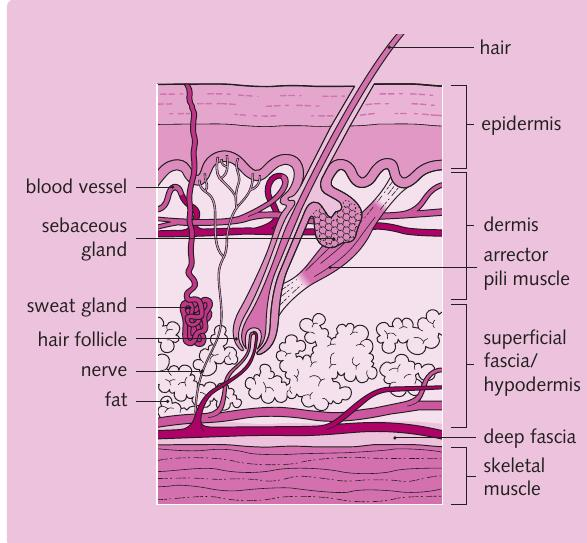

In [101]:
display.display(display.Image(base64.b64decode(relevant_images[0])))